# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the event EASE_THE_ERROR 1.0 Hackathon.

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORTING REQUIRED LIBRARIES**

In [48]:
%matplotlib inline
import os
import shutil
import random
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import torch.nn as nn

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.7.0+cu101


# Preparing Training and Test Sets

In [49]:
class_names = ['normal', 'viral', 'covid']
#root_dir = 'COVID-19 Radiography Database'
root_dir = '/content/drive/My Drive/COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [50]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [51]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

In [52]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])


# Prepare DataLoader

In [53]:
train_dirs = {
    'normal': '/content/drive/My Drive/COVID-19 Radiography Database/normal',
    'viral': '/content/drive/My Drive/COVID-19 Radiography Database/viral',
    'covid': '/content/drive/My Drive/COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [54]:
test_dirs = {
    'normal': '/content/drive/My Drive/COVID-19 Radiography Database/test/normal',
    'viral': '/content/drive/My Drive/COVID-19 Radiography Database/test/viral',
    'covid': '/content/drive/My Drive/COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [55]:
batch_size = 10         #Tuned Hyperparameter

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                      shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,
                                     shuffle = True)

print('Num of training batches', len(dl_train))
print('Num of test batches', len(dl_test))                            

Num of training batches 282
Num of test batches 9


# Data Visualization

In [56]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize = (8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 10, i+1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

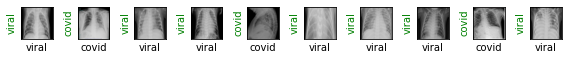

In [57]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

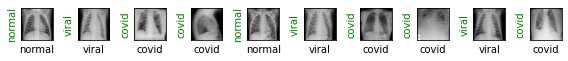

In [58]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [59]:
resnet18 = torchvision.models.resnet18(pretrained = True)       #importing resnet18
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [60]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3)        #importing one fresh fully connected layer for better generalization
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 3e-4)            #training settings

In [61]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)
    conf_matrix = confusion_matrix(preds, labels)
    print(conf_matrix)
    arr= images.numpy()

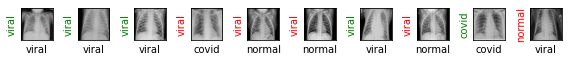

[[0 1 0]
 [3 4 1]
 [0 0 1]]


In [62]:
show_preds()

# Training the Model

In [63]:
def train(epochs):
    val_loss, train_loss = 0, 0
    print('Starting training...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                acc = 0
                val_loss = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                val_loss /= (val_step + 1)
                acc = acc/len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                
                if acc>0.98:
                    print('Performance Condition satisfied..')
                    return
        train_loss /= (train_step + 1)
        print(f'Training loss: {train_loss:. 4f}')
        

Starting training...
Starting epoch 1/1
Evaluating at step 0
Val loss: 0.8666, Acc: 0.6778


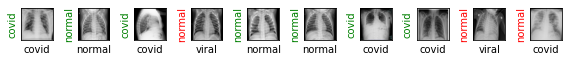

[[3 2 1]
 [0 0 0]
 [0 0 4]]
Evaluating at step 20
Val loss: 1.0122, Acc: 0.8222


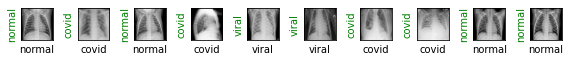

[[4 0 0]
 [0 2 0]
 [0 0 4]]
Evaluating at step 40
Val loss: 0.2625, Acc: 0.8889


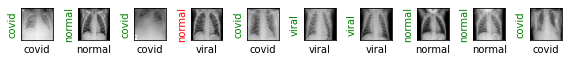

[[3 1 0]
 [0 2 0]
 [0 0 4]]
Evaluating at step 60
Val loss: 0.2663, Acc: 0.9333


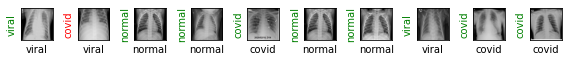

[[4 0 0]
 [0 2 0]
 [0 1 3]]
Evaluating at step 80
Val loss: 0.1897, Acc: 0.9111


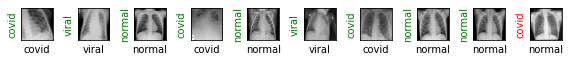

[[4 0 0]
 [0 2 0]
 [1 0 3]]
Evaluating at step 100
Val loss: 0.1268, Acc: 0.9444


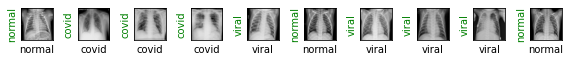

[[3 0 0]
 [0 4 0]
 [0 0 3]]
Evaluating at step 120
Val loss: 0.1910, Acc: 0.9333


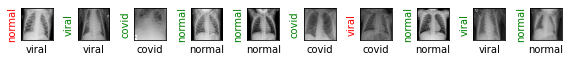

[[4 1 0]
 [0 2 1]
 [0 0 2]]
Evaluating at step 140
Val loss: 0.5871, Acc: 0.8222


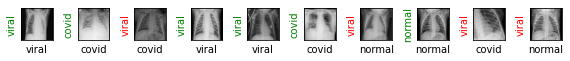

[[1 0 0]
 [2 3 2]
 [0 0 2]]
Evaluating at step 160
Val loss: 0.3033, Acc: 0.9000


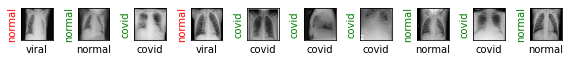

[[3 2 0]
 [0 0 0]
 [0 0 5]]
Evaluating at step 180
Val loss: 0.1152, Acc: 0.9556


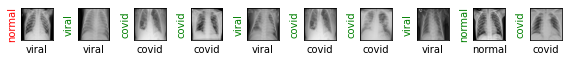

[[1 1 0]
 [0 3 0]
 [0 0 5]]
Evaluating at step 200
Val loss: 0.1931, Acc: 0.9111


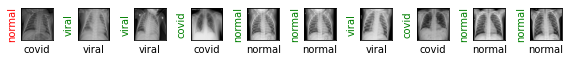

[[4 0 1]
 [0 3 0]
 [0 0 2]]
Evaluating at step 220
Val loss: 0.4067, Acc: 0.9000


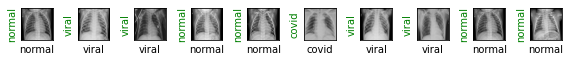

[[5 0 0]
 [0 4 0]
 [0 0 1]]
Evaluating at step 240
Val loss: 0.4559, Acc: 0.8333


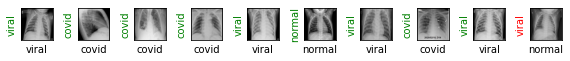

[[1 0 0]
 [1 4 0]
 [0 0 4]]
Evaluating at step 260
Val loss: 0.0623, Acc: 0.9889


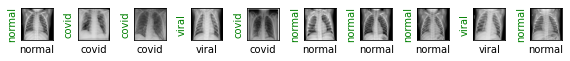

[[5 0 0]
 [0 2 0]
 [0 0 3]]
Performance Condition satisfied..


In [64]:
train(epochs = 1)

In [65]:
torch.save(resnet18.state_dict(), "/content/drive/My Drive/Model2", _use_new_zipfile_serialization=False)

# Final Results

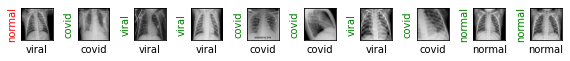

[[2 1 0]
 [0 3 0]
 [0 0 4]]


In [66]:
show_preds()

In [ ]:
print(resnet18)

**LOADING A SINGLE IMAGE**

In [67]:
from PIL import Image
import torchvision.transforms.functional as TF
import cv2 as cv2
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size = (224, 224)),
        torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                        std = [0.229, 0.224, 0.225])
    ])

image = Image.open('/content/drive/My Drive/COVID-19 Radiography Database/covid/COVID-19 (100).png')
def load_image(image):                                      #loading single image from a remote directory
    img = np.array(image, dtype=np.uint8)
    PIL_image = Image.fromarray(img.astype('uint8'))
    x = test_transform(PIL_image)
    return x

In [68]:
def show_images1(images, labels, preds):                    #displaying single images with ground truth labels and the predictions made by the model
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 10, 1, xticks = [], yticks = [])
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = images*std + mean
    images = np.clip(images, 0., 1.)
    plt.imshow(images)
    col = 'green' if (preds) == (labels) else 'red'
    plt.xlabel(f'{class_names[labels]}')
    plt.ylabel(f'{class_names[preds]}', color = col)
    plt.tight_layout()
    plt.show()

**HEAT MAP VISUALIZATION**


In [69]:
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        
        # get the above trained resnet18 network
        self.resnet18 = resnet18
        
        # disect the network to access its last convolutional layer
        self.features_conv = nn.Sequential(*list(resnet18.children())[:-2])
        # get the average pool of the features stem
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        
        # get the classifier of the resnet18
        self.classifier = nn.Sequential(list(resnet18.children())[-1])
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.avg_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

tensor([[-3.0337, -3.1536,  7.2448]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([7.2448], grad_fn=<MaxBackward0>),
indices=tensor([2]))


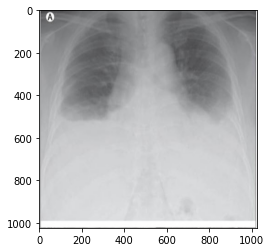

In [144]:
# initialize the VGG model
resnet_18 = Resnet18()

# set the evaluation mode
resnet_18.eval()

# get the image from a directory
img= Image.open('/content/drive/My Drive/COVID-19 Radiography Database/covid/COVID-19 (132).png')
# get the most likely prediction of the model
image = load_image(img)
outputs_ = resnet_18(image.unsqueeze(0))
print(outputs_)
#getting the most likely output
prediction = torch.max(outputs_,1)
print(prediction)
plt.imshow(img)

<built-in method type of Tensor object at 0x7f1e3c35ed38>


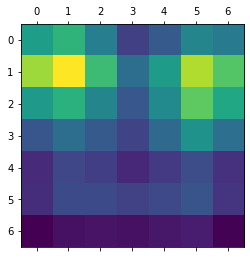

In [145]:
# get the gradient of the most likely output with respect to the parameters of the model
outputs_[:,2].backward(retain_graph = True)

# pull the gradients out of the model
gradients = resnet_18.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = resnet_18.get_activations(image.unsqueeze(0)).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)
# draw the heatmap
plt.matshow(heatmap.squeeze())
print(heatmap.type)


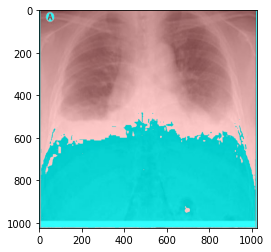

In [146]:
import cv2
#img= Image.open('/content/drive/My Drive/COVID-19 Radiography Database/covid/COVID-19 (133).png')
img = cv2.imread('/content/drive/My Drive/COVID-19 Radiography Database/covid/COVID-19 (132).png')
#plt.imshow(img)
#plt.imshow(img1)
heatmap=np.uint8(heatmap)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
#heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap*0.4+ img

plt.imshow(superimposed_img.astype('uint8'))

#cv2.imwrite('./map.jpg', superimposed_img)
#plt.imshow(heatmap)